## Heston Model
This notebook demonstrates how to implement and visualize the Heston Model using the finmc library, specifically leveraging the class finmc.models.heston.HestonMC.
The Heston model is widely used in quantitative finance to model the stochastic volatility of asset prices.
By capturing volatility clustering and mean reversion, the Heston model serves as a key tool for pricing derivatives, managing portfolio risk, and understanding asset price dynamics over time.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

from finmc.models.heston import HestonMC
from finmc.plots.asset import plot_asset
from finmc.utils.assets import flat_discount, flat_fwds

import matplotlib.pyplot as plt
import seaborn as sns
from sankey_plot import plot_sankey

Create dataset for this model. See [Heston Model Documentation](https://finlib.github.io/finmc/models/heston/) for explanation of model parameters.

In [2]:
# Step 1: Define the Dataset
asset_name = "SPX"
spot = 2900
rate = 0.02
# Create the base dataset for the Heston model
dataset = {
    "MC": {"PATHS": 100_000, "TIMESTEP": 1 / 250, "SEED": 1},
    "BASE": "USD",
    "ASSETS": {
        "USD": flat_discount(rate, 3.0),
        asset_name: flat_fwds(spot, rate, 0.0, 3.0),
    },
    "HESTON": {
        "ASSET": asset_name,
        "INITIAL_VAR": 0.02,
        "LONG_VAR": 0.04,  # Default LONG_VAR added here
        "VOL_OF_VOL": 0.45,
        "MEANREV": 1.5,
        "CORRELATION": -0.85,
    },
}


### Asset Price Simulation and Visualization
The notebook simulates the evolution of asset prices over time, driven by the dynamics of the Heston model.
A single simulation is conducted with default parameters to visualize how asset prices behave under the initial conditions.

Plot: Asset Evolution Over Time

This plot visualizes the time series evolution of the asset price.
It highlights how price paths behave under the initial volatility settings.

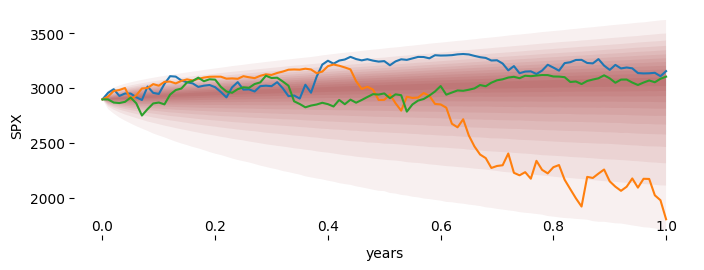

In [3]:
# Step 2: Initialize the Default Heston Model
model = HestonMC(dataset)

# Plot Asset Evolution (Default Dataset)
plot_asset(model, asset_name)

### Dynamic Kernel Density Estimation (KDE) for Asset Price Distributions
To better understand how asset price distributions evolve over time, the notebook employs Kernel Density Estimation (KDE) to visualize price distributions at different time steps.

Instead of using traditional joy plots, KDE plots are generated to show stacked distributions across different time intervals.

Process:

The model is advanced through different time steps (t), and asset prices are recorded at each step.
The KDE plots illustrate how asset price distributions evolve, offering insight into price dispersion over time.


In [4]:
# Step 4: Generate Samples for Different Parameters
times = np.linspace(0.2, 1.0, 5)


def generate_samples(model, times):
    all_prices = []
    all_times = []
    model.reset()
    for t in times:
        model.advance(t)
        prices = model.get_value(asset_name)
        all_prices.extend(prices)
        all_times.extend([f"t={t:4.2f}"] * len(prices))
    return pd.DataFrame({"values": all_prices, "time": all_times})


### Comparing Model Parameters (LONG_VAR, INITIAL_VAR, VOL_OF_VOL, MEANREV, CORRELATION)
The notebook explores the impact of varying Heston model parameters by comparing asset price distributions under different conditions.

In [5]:
# Step 5: KDE Plot Function
def plot_kde(ax, samples_df, title):
    for t in times:
        sns.kdeplot(
            data=samples_df[samples_df["time"] == f"t={t:4.2f}"]["values"],
            ax=ax,
            fill=True,
            label=f"t={t:4.2f}",
            clip=(0, np.max(samples_df["values"])),
            bw_adjust=0.5,
        )
    ax.set_xlabel("Asset Price $S(t)$")
    ax.set_title(title)
    ax.legend()

### Visualization: KDE Plots for Parameter Comparisons
For each parameter, the notebook generates side-by-side KDE plots that display price distributions under two different values.
This allows for easy comparison and interpretation of how specific parameters affect price behavior over time.

Plot: Side-by-Side KDE Comparisons

The left subplot shows the KDE plot for the lower parameter value.
The right subplot displays the KDE plot for the higher parameter value.
By comparing the plots, users can analyze how asset prices evolve under different model assumptions.


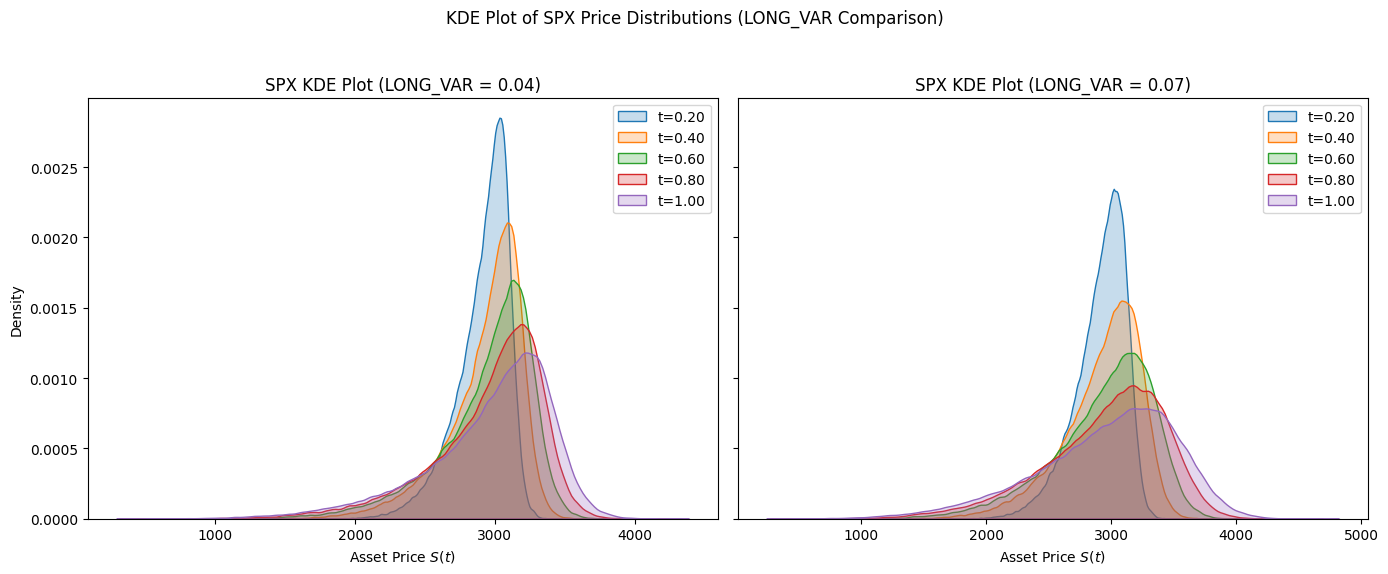

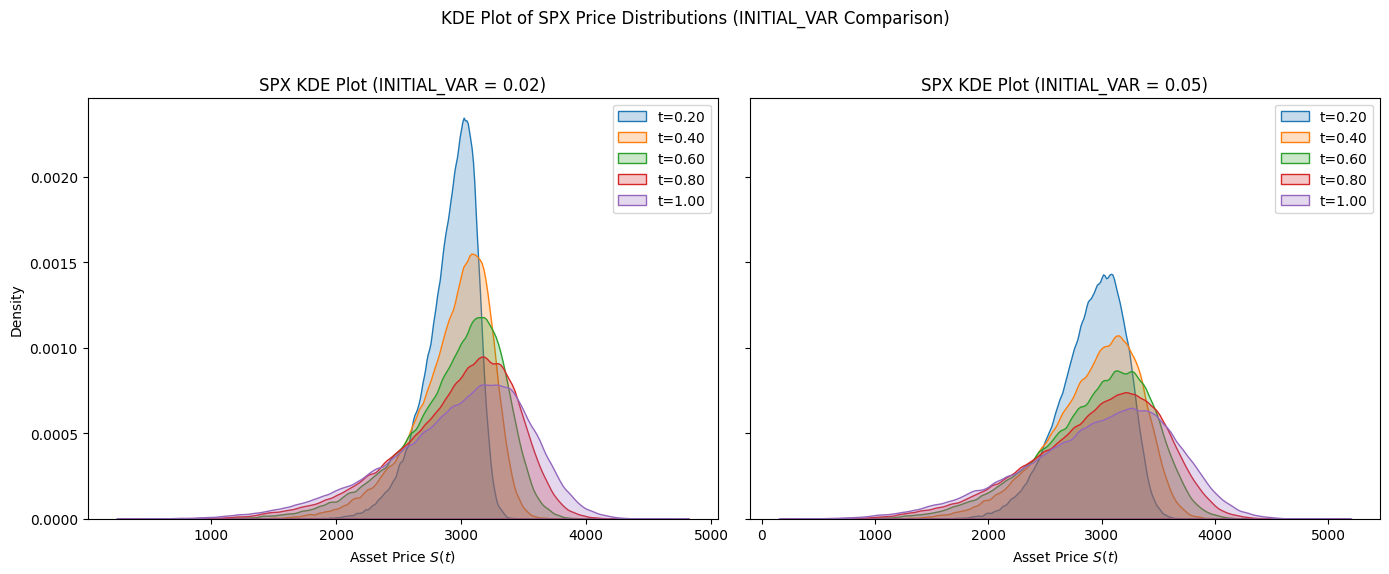

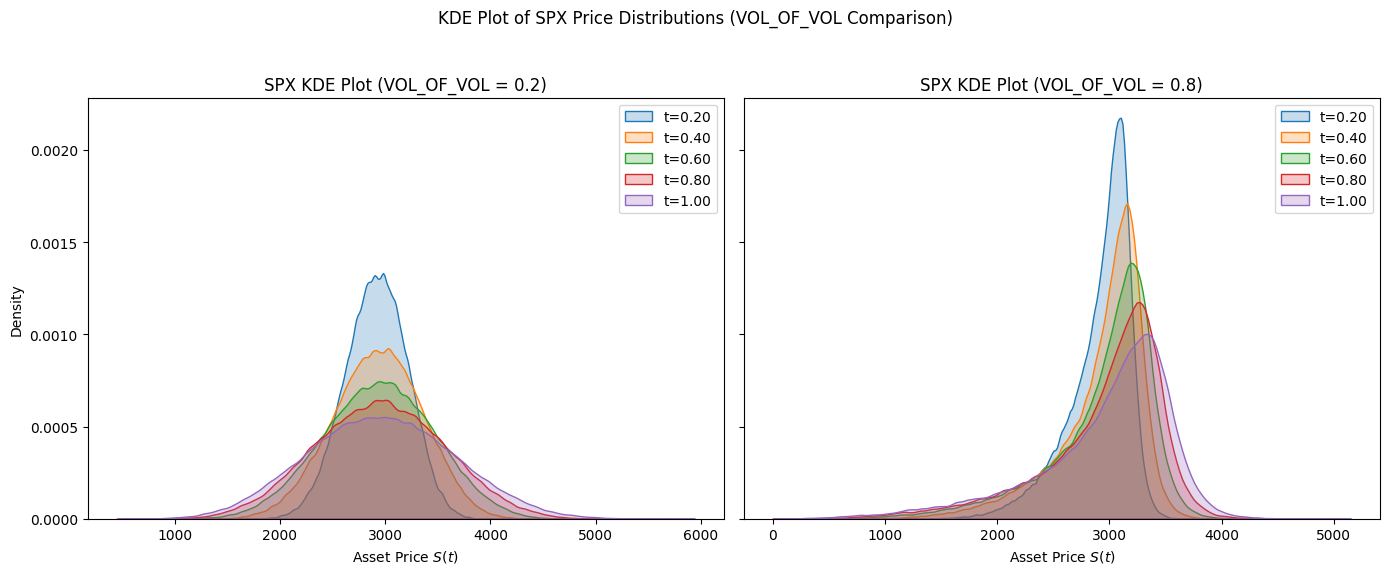

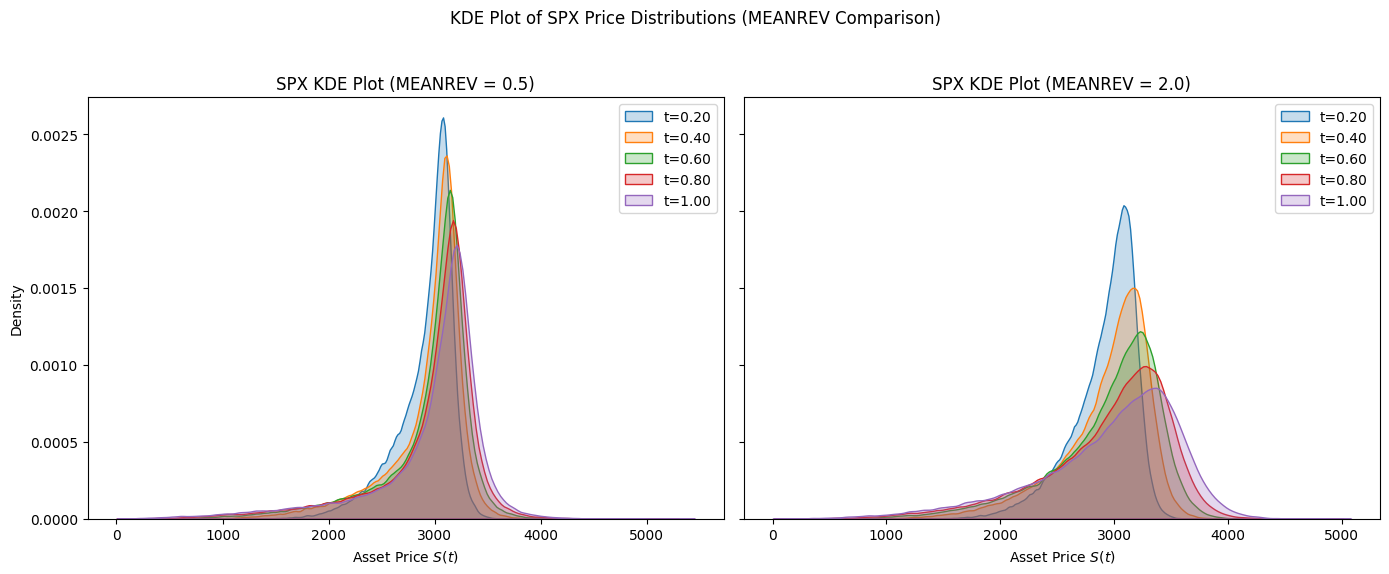

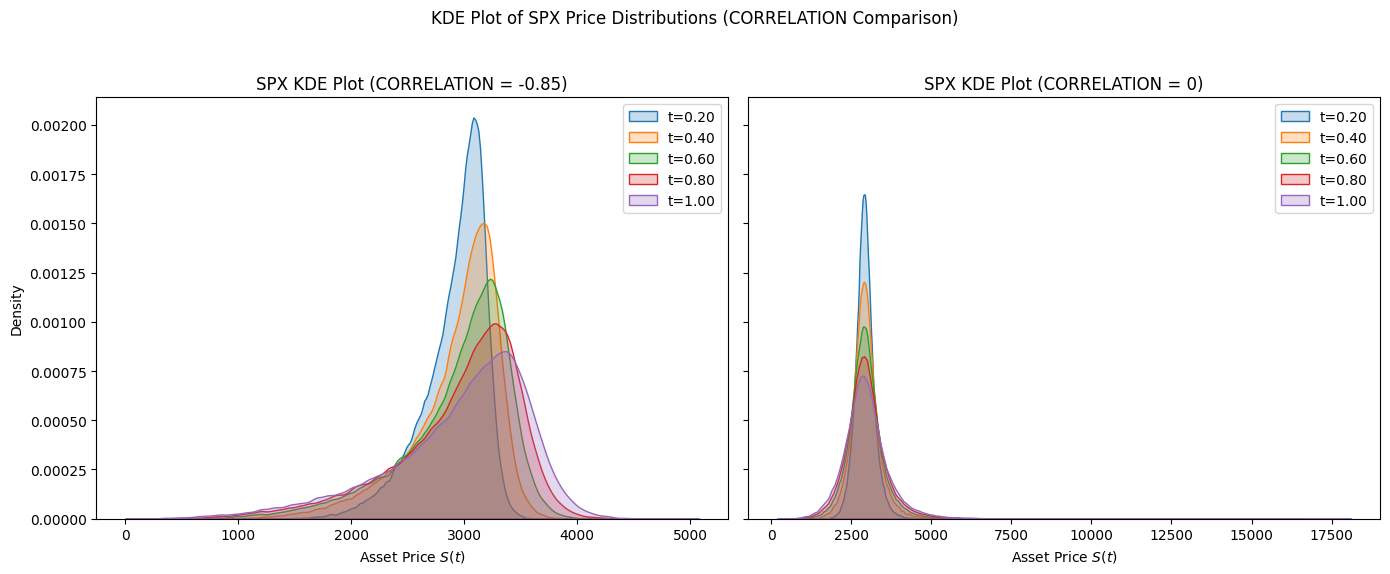

In [6]:
# Step 6: Plot for Different Parameters (Loop)
parameters = [
    ("LONG_VAR", [0.04, 0.07]),
    ("INITIAL_VAR", [0.02, 0.05]),
    ("VOL_OF_VOL", [0.2, 0.8]),
    ("MEANREV", [0.5, 2.0]),
    ("CORRELATION", [-0.85, 0]),
]

for param, values in parameters:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    plt.suptitle(f"KDE Plot of {asset_name} Price Distributions ({param} Comparison)")

    for i, value in enumerate(values):
        dataset["HESTON"][param] = value
        samples_df = generate_samples(model, times)
        plot_kde(axes[i], samples_df, f"{asset_name} KDE Plot ({param} = {value})")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.show()

## Impact of LONG_VAR :

The LONG_VAR parameter represents the long-term variance towards which the stochastic volatility reverts over time.

Higher LONG_VAR (0.07) implies that the volatility itself is higher, leading to greater dispersion in asset prices.

With lower LONG_VAR (0.04), volatility is reduced, resulting in a tighter clustering of asset prices near the mean, which increases the peak density.

### Practical Implications of Peak Decrease:

Risk and Uncertainty:

Higher LONG_VAR introduces more uncertainty, as the asset prices are less predictable and prone to wider fluctuations.
This can lead to increased risks in portfolios containing such assets.
Derivative Pricing:

With higher LONG_VAR, the prices of derivatives, particularly options, increase as the likelihood of extreme price movements grows, impacting hedging strategies and portfolio costs.

## Effect of INITIAL_VAR on Variance:

INITIAL_VAR = 0.02: Represents lower initial variance in the stochastic volatility process. This results in narrower distributions with a slightly right-skewed shape. The lower variance constrains the initial price movements, concentrating asset prices closer to the mean.

INITIAL_VAR = 0.05: Represents higher initial variance, leading to a more normal (Gaussian-like) distribution as the volatility process starts with more randomness. The higher variance spreads the asset prices more evenly across the range.

### Impact on Skewness:

The right skewness observed in both cases reflects the natural behavior of asset price distributions under the Heston model. However, with higher INITIAL_VAR, the effect of skewness becomes less pronounced because the higher variance masks the asymmetry.

Lower INITIAL_VAR implies reduced initial uncertainty, making it easier to predict short-term price movements, but it may underestimate risks in volatile markets.
Higher INITIAL_VAR captures greater initial uncertainty, making it better for risk estimation in dynamic or unstable markets.


## Effect of VOL_OF_VOL on Volatility Dynamics:

VOL_OF_VOL = 0.2: A lower volatility-of-volatility implies more stability in the stochastic variance process. The asset prices tend to follow a predictable path, resulting in a distribution that closely resembles a normal bell curve.

VOL_OF_VOL = 0.8: A higher volatility-of-volatility introduces more randomness and instability in the variance process. This causes larger and more frequent deviations in asset prices, leading to a narrower, peaked, and right-skewed distribution.

### Impact on Skewness:

With higher VOL_OF_VOL, the model captures extreme variations in volatility, amplifying the skewness towards higher asset prices. This reflects the greater likelihood of rare but significant price movements in turbulent markets.

## Effect of MEANREV on Volatility and Convergence:

MEANREV = 0.5: Lower mean reversion implies slower convergence of volatility to its long-term average. This results in more variability and heightened peaks across all time steps. The slower reversion amplifies the clustering effect around the mean value, creating consistently sharper distributions.

MEANREV = 2.0: Higher mean reversion accelerates the stabilization of volatility. As a result, the volatility stabilizes quickly for initial time steps (e.g., t=0.2, 0.4, 0.6), leading to sharper peaks. For later time steps (t=0.8, 1.0), the reversion effect diminishes, resulting in broader distributions.

### Right Skewness:

In both cases, the distributions exhibit right skewness due to the inherent stochastic nature of the Heston model. However, with higher MEANREV (2.0), the skewness is more pronounced at later time steps as the price paths stabilize toward higher values.


## Effect of Correlation on Price Distributions:

Negative Correlation (-0.85): When the correlation between volatility and the asset price is highly negative, the volatility tends to increase when the asset price decreases. This dynamic results in right-skewed distributions, where the lower asset prices are less probable, but the overall variability increases. The peaks are uneven, with distributions at earlier time steps (t=0.2, t=0.4, t=0.6) showing pronounced peaks due to the strong negative feedback mechanism.

Zero Correlation (0): With no correlation between volatility and asset price, the price distributions become more symmetric and resemble a normal bell curve. The volatility is independent of price movements, leading to a more consistent and stable shape across time steps.

### Right Skewness vs Symmetry:

Negative Correlation amplifies the right skewness of distributions as volatility reacts inversely to price changes, creating uneven peaks across time steps.
Zero Correlation removes this dependency, resulting in more symmetric and predictable distributions with reduced tail risks.

In [7]:
# Define your dataset and model
bins = [spot / 1.1, spot * 1.1]
times = [0, 0.3, 0.7, 1.0]

# Call the function to plot Sankey
plot_sankey(model, asset_name, times, bins)